# Image Classification


**Authors:**  
Andrew Sen  
Neo Zhao

In this notebook, we will use various types of neural networks to classify images of birds. The dataset, which can be found [here](https://www.kaggle.com/datasets/gpiosenka/100-bird-species), is a collection of over 75,000 images of birds of 450 different species. We will train each network to classify the images according to the species of bird depicted in each image.

## Data Exploration

First, we'll have to read in the dataset.

In [2]:
import pandas as pd
import os

csvpath = r'../input/100-bird-species/birds.csv'
source_dir = r'../input/100-bird-species'

df = pd.read_csv(csvpath)
df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(source_dir,x))   
classes = sorted(df['labels'].unique())
num_classes = len(classes)
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], 3)

Let's make a graph showing the distribution of classes.

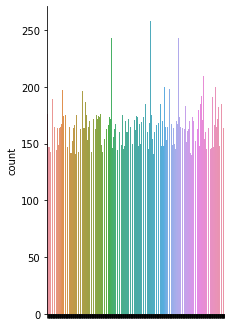

In [2]:
import seaborn as sb

graph = sb.catplot(x='labels', kind='count', data=df)
graph.set(xticklabels=[])
graph.set(xlabel='')
graph

As we can see, the classes are about evenly distributed, with all of them having at least 100 associated images. Some classes have a much larger amount of images, but it shouldn't have too much of an effect on the final results.

## Model Training

First, we'll have to divide the data into train, test, and validate sets.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np

# setting random seeds
np.random.seed(1234)

# train/test/validate split
i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
i = np.random.rand(len(train)) < 0.8
valid = train[~i]
train = train[i]

batch_size = 30
gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(
    train,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

valid_gen = gen.flow_from_dataframe(
    valid,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)


test_gen = gen.flow_from_dataframe(
    test,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

Found 48182 validated image filenames belonging to 450 classes.
Found 11907 validated image filenames belonging to 450 classes.
Found 15037 validated image filenames belonging to 450 classes.


### Sequential Model

In [7]:
num_epochs = 5

# define model topology
model_seq = models.Sequential()
model_seq.add(layers.Input(shape=img_shape))
model_seq.add(layers.Flatten())
model_seq.add(layers.Dense(256, activation='relu'))
model_seq.add(layers.Dense(256, activation='relu'))
model_seq.add(layers.Dense(256, activation='relu'))
model_seq.add(layers.Dense(num_classes, activation='softmax'))

# train
model_seq.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# apply to test data
model_seq.fit(
    x = train_gen,
    epochs = num_epochs,
    validation_data = valid_gen,
    validation_steps = None,
    shuffle = False
)

pred_seq = model_seq.predict(test_gen) # get predictions as label probabilities
pred_seq = np.argmax(pred_seq, axis=1) # get most likely label from probabilities
print('\naccuracy: ', accuracy_score(test_gen.labels, pred_seq))

Epoch 1/5
1607/1607 [==============================] - 206s 128ms/step - loss: 110.1773 - accuracy: 0.0029 - val_loss: 6.1090 - val_accuracy: 0.0031
Epoch 2/5
1607/1607 [==============================] - 204s 127ms/step - loss: 6.1058 - accuracy: 0.0032 - val_loss: 6.1102 - val_accuracy: 0.0031
Epoch 3/5
1607/1607 [==============================] - 206s 128ms/step - loss: 6.1048 - accuracy: 0.0032 - val_loss: 6.1108 - val_accuracy: 0.0031
Epoch 4/5
1607/1607 [==============================] - 202s 126ms/step - loss: 6.1044 - accuracy: 0.0031 - val_loss: 6.1111 - val_accuracy: 0.0031
Epoch 5/5
1607/1607 [==============================] - 198s 123ms/step - loss: 6.1043 - accuracy: 0.0031 - val_loss: 6.1116 - val_accuracy: 0.0031

accuracy:  0.0029926182084192327


The accuracy of this model is extremely bad, being almost 0%. Although the model was only given 5 epochs for training, the accuracy had already plateaued by the second epoch. It's likely because the network is too simple to learn any valuable information about the dataset. Three dense layers with 256 nodes each do not make a complex enough network to process the large inputs.

### Convolutional Neural Network

In [6]:
num_epochs = 30

model_cnn = models.Sequential()
model_cnn.add(layers.Input(shape=img_shape))
model_cnn.add(layers.Conv2D(128, 3, strides=2, padding="same", activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D(3, strides=2, padding="same"))
model_cnn.add(layers.Conv2D(128, 3, strides=2, padding="same", activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.GlobalAveragePooling2D())
model_cnn.add(layers.Dense(num_classes, activation='softmax'))

model_cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_cnn.fit(
    x = train_gen,
    epochs = num_epochs,
    validation_data = valid_gen,
    validation_steps = None,
    shuffle = False
)

pred_cnn = model_cnn.predict(test_gen)
pred_cnn = np.argmax(pred_cnn, axis=1)
print('\naccuracy: ', accuracy_score(test_gen.labels, pred_cnn))

Epoch 1/30
1607/1607 [==============================] - 144s 89ms/step - loss: 5.2833 - accuracy: 0.0464 - val_loss: 5.2095 - val_accuracy: 0.0563
Epoch 2/30
1607/1607 [==============================] - 144s 89ms/step - loss: 4.5272 - accuracy: 0.1254 - val_loss: 4.4753 - val_accuracy: 0.1419
Epoch 3/30
1607/1607 [==============================] - 156s 97ms/step - loss: 4.0400 - accuracy: 0.1986 - val_loss: 4.1044 - val_accuracy: 0.1969
Epoch 4/30
1607/1607 [==============================] - 175s 109ms/step - loss: 3.6605 - accuracy: 0.2607 - val_loss: 3.8514 - val_accuracy: 0.2352
Epoch 5/30
1607/1607 [==============================] - 143s 89ms/step - loss: 3.3562 - accuracy: 0.3132 - val_loss: 3.4461 - val_accuracy: 0.2939
Epoch 6/30
1607/1607 [==============================] - 144s 90ms/step - loss: 3.0954 - accuracy: 0.3585 - val_loss: 3.9787 - val_accuracy: 0.2560
Epoch 7/30
1607/1607 [==============================] - 145s 90ms/step - loss: 2.8772 - accuracy: 0.3948 - val_loss: 

This model's accuracy is considerably improved over the first sequential network. The accuracy is still less than half, but given there are 450 different target classes, this performance is perhaps to be expected of a network that simply consists of two convolutional layers in sequence. The model likely could have improved further with even more epochs, but 30 epochs already took a long time with a GPU. Either way, it seems a more complex network will be required to achieve a test accuracy over 80 or 90%.

### Recurrent Neural Network with ConvLSTM1D

`ConvLSTM1D` is a type of recurrent network layer available in Keras that combines both LSTM and convolution. The training time is extremely long, so the number of epochs was reduced to just 2.

In [4]:
num_epochs = 2

model_rnn = models.Sequential()
model_rnn.add(layers.Input(shape=img_shape))
model_rnn.add(layers.Rescaling(1. / 255))
model_rnn.add(layers.ConvLSTM1D(128, 3, activation='relu'))
model_rnn.add(layers.BatchNormalization())
model_rnn.add(layers.Flatten())
model_rnn.add(layers.Dense(num_classes, activation = 'softmax'))

model_rnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_rnn.fit(
    x = train_gen,
    epochs = num_epochs,
    validation_data = valid_gen,
    validation_steps = None,
    shuffle = False
)

pred_rnn = model_rnn.predict(test_gen)
pred_rnn = np.argmax(pred_rnn, axis = 1)
print('\naccuracy: ', accuracy_score(test_gen.labels, pred_rnn))

2022-12-05 02:09:26.750621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:09:26.871308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:09:26.872086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:09:26.873229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/2


2022-12-05 02:09:33.755933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1607/1607 [==============================] - 2912s 2s/step - loss: 5.9362 - accuracy: 0.0126 - val_loss: 6.0158 - val_accuracy: 0.0115
Epoch 2/2
1607/1607 [==============================] - 3000s 2s/step - loss: 5.4719 - accuracy: 0.0423 - val_loss: 6.0517 - val_accuracy: 0.0167

accuracy:  0.01556161468378001


The accuracy shown is pretty bad, but we think this is only due to having so few epochs to train the model. We think that if the model were to be given 30 epochs like the other models in this notebook, it will have done at least as well as the convolutional network, if not better.

### Pretrained Model

We will take a pretrained model and use transfer learning to apply the model to this particular task. This will jumpstart our model so that it can identify useful features in the data from the outset. Here, we will use the EfficientNetB3 model to make training slightly faster.

In [18]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3

num_epochs = 30

# init base model
base_model = EfficientNetB3(include_top=False, input_shape=img_shape, weights="imagenet", pooling='max')

# set layers past 100 to be untrainable
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_pre = models.Sequential()
model_pre.add(layers.Input(shape=img_shape))
model_pre.add(base_model)
model_pre.add(layers.BatchNormalization())
model_pre.add(layers.Dense(256, activation='relu'))
model_pre.add(layers.Dropout(rate=.2, seed=1234))
model_pre.add(layers.Dense(256, activation='relu'))
model_pre.add(layers.Dropout(rate=.2, seed=1234))
model_pre.add(layers.Dense(num_classes, activation='softmax'))

model_pre.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_pre.fit(
    x = train_gen,
    epochs = num_epochs,
    validation_data = valid_gen,
    validation_steps = None,
    shuffle = False
)

pred_pre = model_pre.predict(test_gen)
pred_pre = np.argmax(pred_pre, axis=1)
print('\naccuracy: ', accuracy_score(test_gen.labels, pred_pre))

Epoch 1/30
1607/1607 [==============================] - 323s 194ms/step - loss: 3.0409 - accuracy: 0.3449 - val_loss: 1.3059 - val_accuracy: 0.6522
Epoch 2/30
1607/1607 [==============================] - 329s 205ms/step - loss: 1.3034 - accuracy: 0.6608 - val_loss: 0.8500 - val_accuracy: 0.7748
Epoch 3/30
1607/1607 [==============================] - 312s 194ms/step - loss: 0.9696 - accuracy: 0.7404 - val_loss: 0.7793 - val_accuracy: 0.7989
Epoch 4/30
1607/1607 [==============================] - 299s 186ms/step - loss: 0.8485 - accuracy: 0.7740 - val_loss: 0.6370 - val_accuracy: 0.8378
Epoch 5/30
1607/1607 [==============================] - 297s 185ms/step - loss: 0.7615 - accuracy: 0.7949 - val_loss: 0.5843 - val_accuracy: 0.8519
Epoch 6/30
1607/1607 [==============================] - 298s 186ms/step - loss: 0.6767 - accuracy: 0.8156 - val_loss: 0.6004 - val_accuracy: 0.8560
Epoch 7/30
1607/1607 [==============================] - 298s 185ms/step - loss: 0.6238 - accuracy: 0.8317 - val_

As we can see, adding the pretrained model drastically improved the accuracy, as was to be expected.

### Analysis

As noted before, the sequential model's performance was extremely bad. This is likely because the network is far too simple to gleam any useful information from a given input. Given that the accuracy is very close to 0% and that the validation accuracy quickly plateaued, the model likely wasn't able to learn any useful information at all.

The CNN was more promising than a simple dense sequential model. This is likely because CNNs are generally useful for learning information from image data. The CNN's poor performance in this notebook speaks more to the complexity of the data than to the power of CNNs. More epochs, more convolutional layers, and more complexity in the network would have all likely improved the performance of the model.

It is hard to properly judge the performance of the RNN because we provided so little time for the model to properly train. The jump in accuracy between the two epochs was greater than what was demonstrated by the prior two models, indicating that at the very least, the RNN was learning more useful information more quickly. As stated before, we believe that with more epochs, this model would have performed at least as well as our CNN. Although RNNs are typically used for processing time-series data, we think that by combing LSTM with convolution, the network would be able to converge on a solution in a smaller number of iterations.

And as expected, the model based on the pretrained model was by far the best. Pretrained models are already primed to extract useful information that can help to differentiate images. This gives the network a headstart towards learning information that improves performance on this specific task. Furthermore, by using the EfficientNet model, the overall training time was not much worse than that of the CNN. This demonstrates that for any image classification task, using a pretrained model can immediately save a lot of time and effort.